# Mental Health Chatbot

## Introduction

## SDGs

## Chatbots

Chatbots are computer programs that simulate human conversation with an end user. They are used for a variety of purposes, including customer service, marketing, and entertainment.

Chatbots can be broadly categorized into two types:

**Rule-based chatbots**: These chatbots follow predefined rules and patterns to respond to user queries. They are relatively simple to build but lack flexibility and can only handle a limited range of questions. Furthermore, they are not able to produce new text.

**Machine learning chatbots**: These chatbots utilize machine learning algorithms to learn from user interactions and improve their responses over time. They are more complex to build but offer greater flexibility and can handle a wider range of queries.

### How chatbots work

1. User Input: The user types or speaks a query.
2. Preprocessing: The input is cleaned, tokenized, and transformed into a suitable format.
3. Intent Recognition: The chatbot identifies the user's intent (e.g., asking a question, making a request, providing feedback).
4. Entity Extraction: Relevant entities are extracted from the query (e.g., product names, locations, dates).
5. Response Generation:
  - Rule-Based Responses: Predefined responses for specific intents.
  - Generative Models: Generating text from scratch, using natural language processing.
6. Response Delivery: The chatbot delivers the generated response to the user.

In this project, two machine learning approaches for natural language processing (NLP) are described and compared. They use the seq2seq architecture as described in the next section.

## Seq2seq

Seq2Seq (Sequence-to-Sequence) is a type of neural network architecture commonly used in machine learning, particularly for tasks involving sequential data. It is well suited for chatbots because it allows the model to process an input sequence (e.g., a user's query) and generate an output sequence (e.g., a chatbot's response):

1. **Encoder:**
   * Takes an input sequence (e.g., a sentence) and processes it word by word.
   * Each word is represented as a numerical vector.
   * The encoder processes these vectors sequentially, capturing the underlying meaning and context.
   * The final state of the encoder, often called the "context vector," encapsulates the essence of the input sequence.

2. **Decoder:**
   * Generates the output sequence, one token at a time (e.g., word by word).
   * It starts with a special "start" token and uses the context vector from the encoder as initial input.
   * At each time step, the decoder predicts the next token based on its current state and the previous output token.
   * This process continues until a special "end" token is generated, indicating the end of the sequence.

The following aspects need to be considered, especially when comparing Seq2Seq models to classical rule-based models.

**Positive aspects:**

* Seq2Seq models can capture the context of a conversation, allowing for more relevant and coherent responses.
* They can generate novel text.
* They can handle complex and open-ended queries that require understanding and reasoning.

**Negative aspects:**

* Requires large amounts of high-quality training data to create usable models.
* Can be computationally expensive to train and deploy.
* May sometimes generate incorrect or nonsensical responses.

### Relationship to common ML concepts

#### Problem type

In the context of chatbots, the primary problem being solved is **sequence-to-sequence generation**. This involves taking a given input sequence and generating a corresponding output sequence. This problem is fundamentally different from classification, where the goal is to assign a fixed label to an input.

#### Common loss function

A common loss function used for seq2seq tasks is **cross-entropy loss**. It measures the difference between the predicted probability distribution over possible output sequences and the actual probability distribution (the ground truth).

#### Determining the number of classes

In the case of sequence-to-sequence generation, the concept of *classes* is not directly applicable. Instead, approaches deal with a vast vocabulary of words and phrases that can be used to construct responses.

The number of potential output tokens (words or subwords) determines the size of the output vocabulary. This vocabulary size can be:

1. **Fixed vocabulary:** A predefined set of words or tokens that the model is trained on.
2. **Dynamic vocabulary:** A vocabulary that expands as the model encounters new words during training or inference.

The choice of vocabulary size depends on factors such as the specific application, computational resources, and the desired level of language complexity.

**Example:**

The input sequence is 'What day is it?'

The output sequence is 'It is Monday.'

The vocabulary consists of the used output tokens, in this case:

```
['It', 'is', 'Monday', '.']
```

Therefore, the number of classes to predict would be equal to 4 for this example.

In practice, much more training data is used, resulting in far greater vocabularies.

## Attention Mechanism

**Attention Mechanism in Encoder-Decoder Models**

In traditional encoder-decoder models, the encoder processes the input sequence and compresses it into a fixed-length vector, known as the context vector. The decoder then uses this context vector to generate the output sequence. However, this approach can be limiting, especially for long input sequences, as it's difficult to capture all the relevant information in a single vector.

**Attention Mechanism** addresses this limitation by allowing the decoder to focus on different parts of the input sequence at different timesteps during the decoding process. It does this by assigning weights to different parts of the input sequence, indicating their relevance to the current output token:

1. **Encoder:** The encoder processes the input sequence and generates a hidden state for each input token.
2. **Decoder:**
    - At each timestep, the decoder calculates an attention score for each encoder hidden state.
    - These scores represent the relevance of each encoder hidden state to the current decoder state.
    - The scores are then normalized using a softmax function to obtain attention weights.
    - The attention weights are used to compute a weighted sum of the encoder hidden states, creating a context vector that is specific to the current decoding step.
    - The decoder uses this context vector, along with its previous hidden state, to generate the next output token.

**Pros:**

* Attention mechanisms allow the model to focus on the most relevant parts of the input sequence, leading to more accurate outputs.
* By selectively attending to different parts of the input, the model can handle longer sequences more effectively.

An attention mechanism is used in the second approach of this project.

## BLEU score

**BLEU (Bilingual Evaluation Understudy)** is a metric used to evaluate the quality of machine-generated text, particularly in the context of machine translation, but also chatbots. It compares the generated text to one or more reference translations (answers) created by human experts.

**How does BLEU work?**

1. **N-gram Precision:**
   - It breaks down the generated text and reference answers into n-grams (sequences of n consecutive words).
   - It calculates the precision of each n-gram, which is the proportion of n-grams in the generated text that also appear in the reference answers.
   - Typically, n-grams of different lengths (e.g., unigrams, bigrams, trigrams, and four-grams) are considered.

2. **Brevity Penalty:**
   - To avoid overly short answers that might have high precision but lack content, a brevity penalty is applied.
   - If the generated text is shorter than the reference answers, a penalty is imposed to discourage overly concise outputs.

3. **Geometric Mean:**
   - The final BLEU score is calculated as the geometric mean of the precision scores for different n-grams, weighted by their importance.
   - This ensures that the model is rewarded for producing accurate answers at multiple levels of granularity.

**Interpretation:**

- A higher BLEU score indicates that the machine-generated text is more similar to human-quality answers.
- However, it's important to note that BLEU is not a perfect metric. It can be sensitive to certain linguistic nuances and may not fully capture semantic similarity.
- A high BLEU score should be combined with human evaluation to assess the overall quality of the generated text.

BLEU scores are used to compare the approaches presented in this project.

## Mental Health Chatbot project outline

Following are the most important facts about this project.

- Number of approaches to compare: 2
- Architecture type: seq2seq
- Dataset used: Mental health questions and answers consisting of 97 rows
- Model input size: equal to the number of tokens in the question vocabulary
- Model output size (classes): equal to the number of tokens in the answer vocabulary
- Loss function: cross-entropy loss
- Number of epochs: Models are trained until they start to overfit
- Model evaluation: comparison of BLEU scores

The main differences of the two approaches are:

- More sophisticated creation of the input and output vocabularies in the second approach
- Encoder/decoder model of the second approach uses an attention mechanism

# The first model

The following procedure to train a mental health chatbot is based on this Jupyter Notebook from GitHub https://github.com/pandeyanuradha/Chatbot-for-mental-health/blob/main/Models/Generative_based.ipynb.

## Loading data and preliminary analysis

This code snippet sets up the environment for the mental health chatbot by installing necessary libraries from a `requirements.txt` file using `pip`.

In [3]:
%cd mental-health-chatbot/

/home/jovyan/mental-health-chatbot


In [4]:
# Install dependencies

%pip install -r 'requirements.txt'

Note: you may need to restart the kernel to use updated packages.


In [5]:
import random
import numpy as np
import torch

seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

The following code snippet imports necessary libraries for building and visualizing the mental health chatbot. It imports `re` for regular expressions, `random` for generating random numbers, `pandas` for data manipulation, `numpy` for numerical operations, `plot_model` from `tensorflow.keras.utils` for visualizing the model structure, `load_model` from `keras.models` for loading pre-trained models, and `matplotlib.pyplot` for plotting graphs. Additionally, it sets a pandas option to suppress chained assignment warnings. These imports and configuration settings prepare the environment for subsequent steps in the chatbot development process.

In [54]:
import re
import pandas as pd
from tensorflow.keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)
path_to_csv = 'mentalhealth.csv'

Pandas is used to load the training data from the `mentalhealth.csv` file into a DataFrame.

In [55]:
data = pd.read_csv(path_to_csv)

5 random rows of the DataFrame are examined.

In [56]:
data.sample(5)

,Question_ID,Questions,Answers
40,4134858,How can I manage grief?,While a lot of people think of grief in terms ...
78,9020440,What is cyclothymic disorder?,Cyclothymic disorder is a subtype of bipolar d...
93,7807643,"If cannabis is dangerous, why are we legalizin...","Cannabis smoke, for example, contains cancer-c..."
91,4294616,How can I find help for an alcohol or drug use...,Seeking to make changes in the way you use sub...
63,8471978,I was prescribed an antidepressant or other ps...,"If you’re concerned about your medications, it..."


The DataFrame has three columns:

1.   `Question_ID`: the unique ID of the row
2.   `Questions`: mental health related questions
3.   `Answers`: mental health related answers

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Question_ID  97 non-null     int64 
 1   Questions    97 non-null     object
 2   Answers      97 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


There are 3 columns and 97 rows in the dataset.

In [58]:
data.shape

(97, 3)

`data.isna().sum()` helps identify the presence and count of missing values within the dataset, allowing to assess data quality and potentially handle missing values before proceeding with further analysis or model training. No values are missing in this dataset.

In [59]:
data.isna().sum()

,0
Question_ID,0
Questions,0
Answers,0


This code block focuses on cleaning and preparing the 'Answers' column of the dataset for further use. It iterates through each answer in the dataset and applies a series of regular expression substitutions to remove or replace specific characters and patterns. Special characters that interfere with model training are removed. They don't contribute to the meaning of text when processed by algorithms and can introduce errors or confusion. Therefore, it's necessary to remove them during text analysis.



In [60]:
# data preprocessing

for i in range(data.shape[0]):
  data.loc[i, 'Answers'] = re.sub(r'\n', ' ', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub('\(', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'\)', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r',', ' ', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'-', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'/', '', data.loc[i, 'Answers'])

In the following section a list of question and answer pairs is created. It is used in the following steps of the procedure.

In [61]:
pairs = []

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]), data['Answers'][i]))

In [62]:
pairs[0]

('What does it mean to have a mental illness?',
 "Mental illnesses are health conditions that disrupt a person's thoughts  emotions  relationships  and daily functioning.")

## Data preprocessing

The following code snippet creates lists of questions, answers, question word counts and answer word counts. `<START>` and `<END>` tokens are added to the beginning and end of each answer to help the model understand the start and end of a response. All indivudial words in the questions and answers are added to vocabulary sets.

> Vocabulary in NLP refers to the set of unique words that the system knows from a corpus. It's crucial because it forms the basis of how machines interpret the texts. Each word in the vocabulary is indexed and often given a vector representation that captures its meaning and relation to other words.

-- A S M Morshedul Hoque

In [63]:
questions = []
answers = []
question_tokens = set()
answer_tokens = set()

for line in pairs:
  question, answer = line[0], line[1]

  questions.append(question)

  # Splitting words from punctuation
  answer = " ".join(re.findall(r"[\w']+|[^\s\w]", answer))

  # Redefine answer and append it to answers
  answer = '<START> ' + answer + ' <END>'

  answers.append(answer)

  for token in re.findall(r"[\w']+|[^\s\w]", question):
    if token not in question_tokens:
      question_tokens.add(token)

  for token in answer.split():
    if token not in answer_tokens:
      answer_tokens.add(token)

question_tokens = sorted(list(question_tokens))
answer_tokens = sorted(list(answer_tokens))
num_encoder_tokens = len(question_tokens)
num_decoder_tokens = len(answer_tokens)

In [64]:
questions[:5]

['What does it mean to have a mental illness?',
 'Who does mental illness affect?',
 'What are some of the warning signs of mental illness?',
 'Can people with mental illness recover?',
 'What should I do if I know someone who appears to have the symptoms of a mental disorder?']

In [65]:
answers[:5]

["<START> Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning . <END>",
 '<START> Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background . <END>',
 '<START> Symptoms of mental health disorders vary depending on the type and severity of the condition . <END>',
 '<START> When healing from mental illness early identification and treatment are of vital importance . <END>',
 '<START> We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional . <END>']

This code snippet is creating dictionaries to map words to numerical indices and vice versa for both the questions (input) and the answers (target). This is a common step in NLP because machine learning models work with numbers, not raw text.

In [66]:
input_features_dict = dict([(token, i) for i, token in enumerate(question_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(answer_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [67]:
print('There are {} tokens in the input (question) vocabulary'.format(len(input_features_dict)))
print('There are {} tokens in the target (answer) vocabulary'.format(len(target_features_dict)))

There are 282 tokens in the input (question) vocabulary
There are 3101 tokens in the target (answer) vocabulary


## Encoder - Decoder Model

In the following code section one-hot encoded input and target sequences are created for model training.

One-hot encoding is a method for converting each token into a binary vector. This allows machine learning models to work with categorial data.

Neural networks require inputs of consistent shapes. Therefore, the maximum sequence lengths set the dimensions for the longest possible sequence, ensuring each sequence fits within the tensor shape. This avoids dimension mismatches that would cause errors during model training.

Not all input or output sequences will be as long as the maximum sequence length. So, sequences that are shorter get "padded" with zeros up to the maximum length.

Each token in the sequences is represented as a vector. A vector has a length equal to the vocabulary size and a specific position corresponding to the token's index in the vocabulary is set to 1, while all other positions are 0.

`decoder_target_data` is offset by one timestep; this is used for teacher forcing during training, where the target output at time `t` depends on the decoder input at time` t-1`.




In [68]:
def create_one_hot_vectors(questions, answers):
  max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in questions])
  max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in answers])

  encoder_input_data = np.zeros(
      (len(questions), max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(questions), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(answers), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')

  for line, (input_doc, target_doc) in enumerate(zip(questions, answers)):
      for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
          encoder_input_data[line, timestep, input_features_dict[token]] = 1

      for timestep, token in enumerate(target_doc.split()):
          decoder_input_data[line, timestep, target_features_dict[token]] = 1
          if timestep > 0:
              decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1

  return encoder_input_data, decoder_input_data, decoder_target_data

This code snippet splits a dataset of `questions` and `answers` into training, testing, and validation sets, ensuring reproducibility with a fixed `random_state`. The initial split allocates 70% of the data to training and 30% to a combined "other" set. The "other" set is then further divided into testing (70%) and validation (30%) subsets. After splitting, the data is processed using a `create_one_hot_vectors` function, which converts the questions and answers into three components: encoder input data, decoder input data, and decoder target data. These components are formatted as one-hot or integer-encoded vectors, preparing them for use in a sequence-to-sequence machine learning model. The resulting data subsets are ready for training, validation, and testing phases.

In [69]:
from sklearn.model_selection import train_test_split

train_questions, other_questions = train_test_split(questions, test_size=0.3, random_state=1)
train_answers, other_answers = train_test_split(answers, test_size=0.3, random_state=1)

test_questions, val_questions = train_test_split(other_questions, test_size=0.3, random_state=1)
test_answers, val_answers = train_test_split(other_answers, test_size=0.3, random_state=1)

train_encoder_input_data, train_decoder_input_data, train_decoder_target_data = create_one_hot_vectors(train_questions, train_answers)
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = create_one_hot_vectors(test_questions, test_answers)
val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = create_one_hot_vectors(val_questions, val_answers)

The shapes of the encoder and decoder arrays:

**67**: The number of input sequences (the number of rows in `questions`).

**53**: The maximum length (in terms of tokens) of input sequences (`max_encoder_seq_length`), i.e., the longest sequence length in `questions`.

**282**: The size of the input vocabulary (`num_encoder_tokens`), representing the total number of unique tokens in the questions dataset.

In [70]:
train_encoder_input_data.shape

(67, 53, 282)

**67**: The number of output sequences (the number of rows in `answers`).

**1642**: The maximum length (in tokens) of output sequences (max_decoder_seq_length), i.e., the longest sequence length in `answers`.

**3101**: The size of the output vocabulary (`num_decoder_tokens`), representing the total number of unique tokens in the answers dataset.

In [71]:
train_decoder_target_data.shape

(67, 1642, 3101)

## Training

The following code snippet is essentially building the core of a chatbot using a specific type of neural network architecture called an encoder-decoder model with LSTM (Long Short-Term Memory) layers. LSTM is a type of recurrent neural network layer that's good at processing sequential data like text.

In [131]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# This determines the size of the internal representation of the data within
# the LSTM units. A higher dimensionality can capture more complex patterns
# but may increase computational cost.
dimensionality = 256

# Specifies the batch size for training. The batch size is the number of
# samples processed before the model's internal parameters are updated.
batch_size = 12

# Defines the number of training epochs. An epoch is one complete pass
# through the entire training dataset.
epochs = 20

# This code snippet defines the encoder part of a sequence-to-sequence model,
# where encoder_inputs is created as an input layer to receive variable-length
# sequences. An LSTM layer, encoder_lstm, processes this input to understand the
# sequence and produces encoder_outputs along with its internal states
# (state_hidden, state_cell), which are then stored as encoder_states to be
# passed to the decoder, effectively capturing the essence of the input sequence.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

# The decoder takes the encoded information from the encoder, processes it
# step-by-step using the LSTM, and uses the Dense output layer to predict the
# next word in the response, ultimately generating a complete response sequence.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# The `softmax` activation function converts the output of the Dense layer
# into probabilities. Each probability represents the likelihood of a particular
# token being the next word in the response.
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

The following line creates the final training model by combining the encoder and decoder components.

In [132]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

This model is structured for generating sequences, where an input sequence is encoded and then decoded to produce an output sequence.

In [133]:
training_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, None, 282)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, None, 3101)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ [(None, 256), (None,   │        551,936 │ input_layer_21[0][0]   │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, None, 256),    │      3,438,592 │ input_layer_22[0][0],  │
│                           │ (None, 256), (None,    │                │ lstm_10[0][1],         │
│                           │ 256)]                  │                │ lstm_10[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, None, 3101)     │        796,957 │ lstm_11[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,787,485 (18.26 MB)

 Trainable params: 4,787,485 (18.26 MB)

 Non-trainable params: 0 (0.00 B)

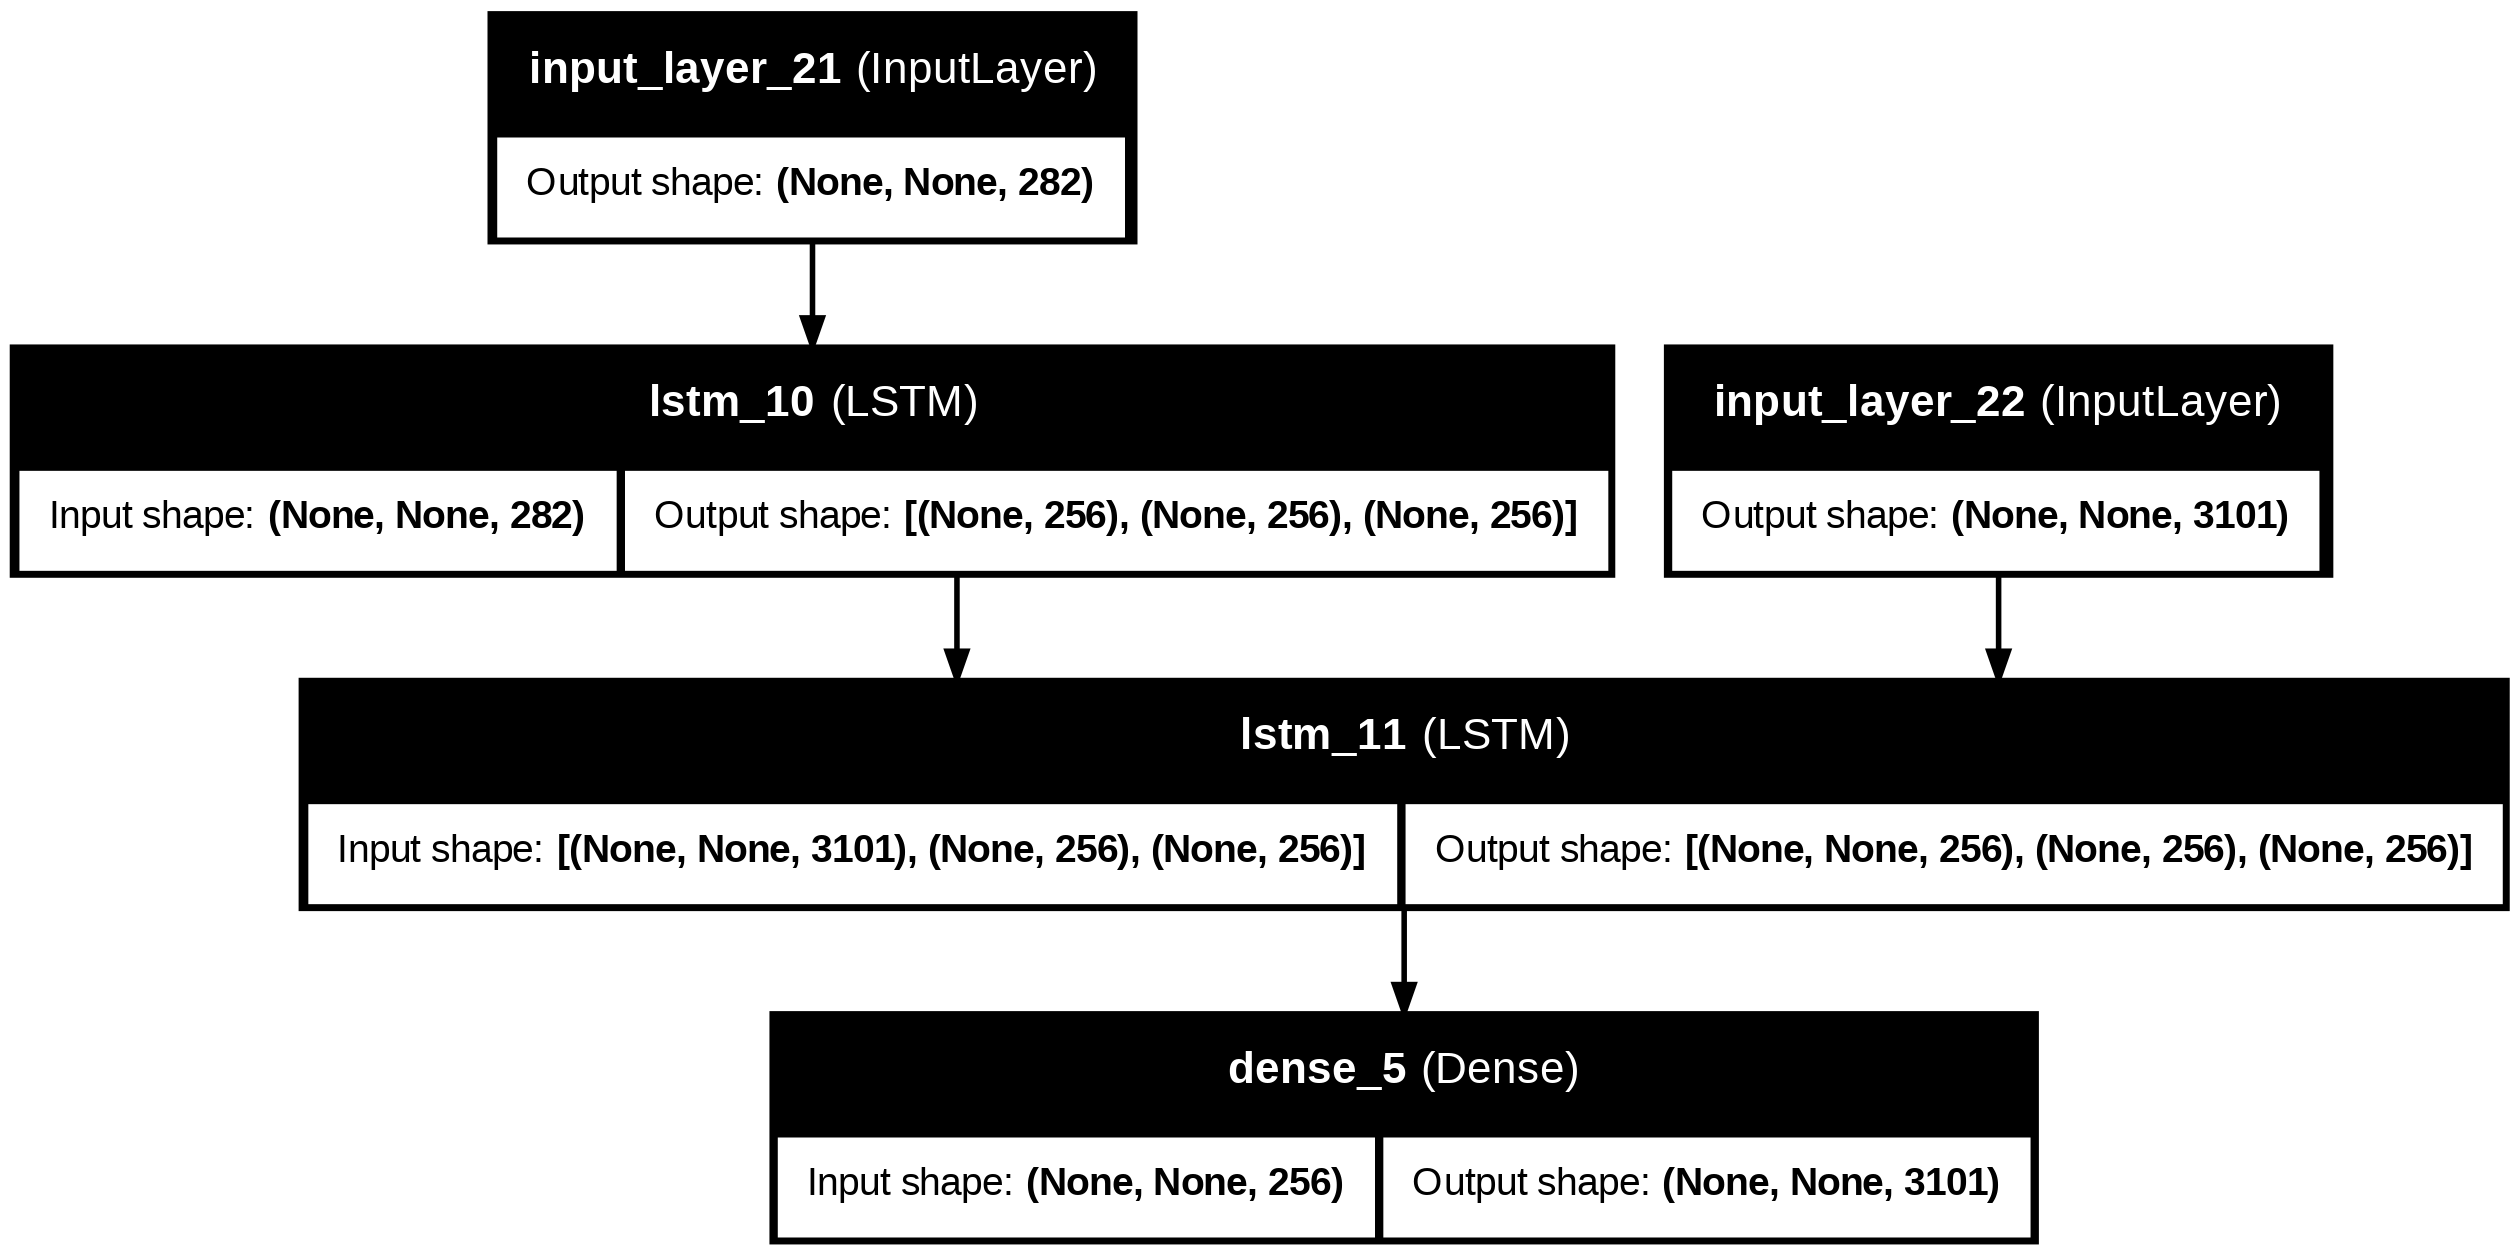

In [134]:
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

The following code compiles the model using the `adam` optimizer and `categorical_crossentropy` loss function (suitable for one-hot encoded targets). It then trains `training_model` on `train_encoder_input_data` and `train_decoder_input_data` (the input sequences for the encoder and decoder) to predict `train_decoder_target_data`, with training running for the specified number of epochs and batch size, and using the previously designated validation data for validation. Finally, the trained model is saved to a file named `training_model.keras` for future use.

In [136]:
training_model.compile(optimizer='adam', loss='categorical_crossentropy')
history1=training_model.fit([train_encoder_input_data, train_decoder_input_data], train_decoder_target_data, batch_size = batch_size, epochs = epochs, validation_data=([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data))
training_model.save('training_model.keras')

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 662ms/step - loss: 1.0342 - val_loss: 2.4573
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - loss: 1.0208 - val_loss: 2.4515
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - loss: 0.9413 - val_loss: 2.4487
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - loss: 0.8653 - val_loss: 2.4473
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - loss: 0.7855 - val_loss: 2.4475
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - loss: 0.9926 - val_loss: 2.4472
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - loss: 0.9972 - val_loss: 2.4466
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - loss: 0.9579 - val_loss: 2.4467
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - loss: 0.9053 - val_loss: 2.4479
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step - loss: 0.7878 - val_loss: 2.4459
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - loss: 0.7831 - val_loss: 2.4439
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 0.9784 - val_lo

Training and validation loss are not improving over the training period.

Due to the considerably higher validation loss, the model shows signs of **overfitting**. This suggests that the model is fitting the training data too closely, and its performance on unseen data could be improved by using techniques like early stopping, regularization, or using more training data.

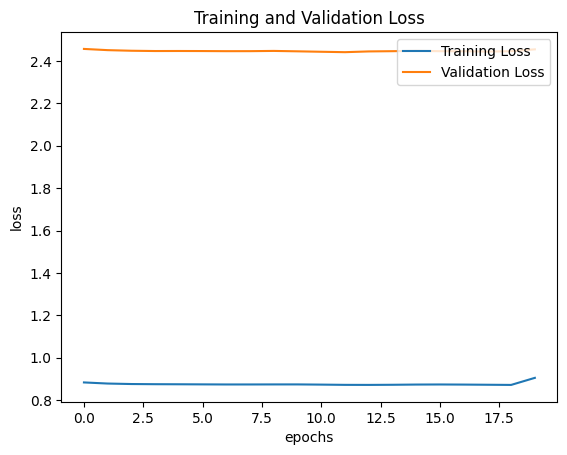

In [137]:
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Inference

This code defines and prepares components for the sequence-to-sequence model for inference. The `decode_response` function implements the decoding logic: given an input sequence, it uses the encoder to obtain initial states and iteratively predicts tokens using the decoder until the end of the sequence is reached, constructing a response token by token. This enables the model to perform inference on new inputs.

In [114]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in questions])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in answers])

training_model = load_model('training_model.keras')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)

    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    #A variable to store our response word by word
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token

          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.

          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

The following function converts a user-provided string into a one-hot encoded 3D matrix representation suitable for input to the sequence-to-sequence model's encoder.

In [115]:
def string_to_matrix(user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

In [116]:
def answer_question(question):
    matrix = string_to_matrix(question)
    return decode_response(matrix)

The responses of this original model are not accurate, due to the simplicity of the used LSTM model and the limited set of input data.

The model described in the subsequent sections aims at improving the quality while still being constrained by the limited amount of input data.

In [130]:
answer_question('I feel sad')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

" conference conference conference opinion readers conference fragmented fragmented fragmented fragmented injuries injuries injuries injuries injuries injuries hoarding hoarding Children depressive > key > key metabolized metabolized metabolized metabolized ordered ordered puts Stress disprove counselling Friday Friday entire known effective faces faces sharing preparing Sorting precautions Educate Sorting fairly offer consumers Try goal Conditions Exercise human Or i chronic Obsessivecompulsive confused collected collected counterproductive conflict conflict conflict conflict expressing expressing ready media media schools unexplainable unexplainable campuses okay held held potential afraid afraid art solutionsfocused solutionsfocused solutionsfocused impacts trails Mainland rarely Mainland cagetsupportvirtual Care DID Along expected HealthLink 18007842433 Parks Parks forms rarely Assistance toll actively Wellness propylene DVD DVD moving obsessivecompulsive taking interpret myth myth

# Model Improvements

As previously shown, the initial model tends to overfit.

In the following sections, different techniques are applied to improve the quality of the model. The approach is inspired by this Jupyter Notebook: https://github.com/bentrevett/pytorch-seq2seq/blob/main/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb.

## Data preprocessing

The newest version of `torchtext` is not compatible with the installed `torch` version. Therefore, the following index URL is specified to gather compatible packages.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm

In [7]:
import pandas as pd

In [116]:
dataset = pd.read_csv('mentalhealth.csv')

In [117]:
dataset.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


In [118]:
from sklearn.model_selection import train_test_split

In [119]:
train_data, other_data = train_test_split(dataset, test_size=0.3, random_state=1)

test_data, val_data = train_test_split(other_data, test_size=0.3, random_state=1)

In [120]:
train_data.head()

,Question_ID,Questions,Answers
74,4893447,What’s the difference between anxiety and an a...,Anxiety is a normal reaction to many different...
56,5981663,What is MSP?,MSP stands for Medical Services Plan. It’s a h...
96,3221856,What is the evidence on vaping?,"""Vaping"" is the term for using a device where ..."
44,7009409,How can I see a counsellor?,You can find directories of counsellors throug...
54,2176317,How can I pay for mental health care?,Mental health services provided through the go...


In [121]:
!python -m spacy download en_core_web_sm
en_nlp = spacy.load("en_core_web_sm")

2364.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.1 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [122]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [123]:
sos_token = "<sos>"
eos_token = "<eos>"

def tokenize(input):
  max_length = 1_000

  token_list = []
  for value in input:
    tokens = [token.text for token in en_nlp.tokenizer(value)[:max_length]]
    tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    token_list.append(tokens)
  return token_list

In [124]:
def tokenize_questions_and_answers(dataset):
    t_questions = tokenize(dataset['Questions'])
    t_answers = tokenize(dataset['Answers'])

    dataset['t_Questions'] = t_questions
    dataset['t_Answers'] = t_answers

In [125]:
tokenize_questions_and_answers(train_data)
tokenize_questions_and_answers(test_data)
tokenize_questions_and_answers(val_data)

In [126]:
train_data.head(5)

,Question_ID,Questions,Answers,t_Questions,t_Answers
74,4893447,What’s the difference between anxiety and an a...,Anxiety is a normal reaction to many different...,"[<sos>, what, ’s, the, difference, between, an...","[<sos>, anxiety, is, a, normal, reaction, to, ..."
56,5981663,What is MSP?,MSP stands for Medical Services Plan. It’s a h...,"[<sos>, what, is, msp, ?, <eos>]","[<sos>, msp, stands, for, medical, services, p..."
96,3221856,What is the evidence on vaping?,"""Vaping"" is the term for using a device where ...","[<sos>, what, is, the, evidence, on, vaping, ?...","[<sos>, "", vaping, "", is, the, term, for, usin..."
44,7009409,How can I see a counsellor?,You can find directories of counsellors throug...,"[<sos>, how, can, i, see, a, counsellor, ?, <e...","[<sos>, you, can, find, directories, of, couns..."
54,2176317,How can I pay for mental health care?,Mental health services provided through the go...,"[<sos>, how, can, i, pay, for, mental, health,...","[<sos>, mental, health, services, provided, th..."


In [127]:
test_data.head(5)

,Question_ID,Questions,Answers,t_Questions,t_Answers
52,6779222,Where can I find free or low-cost counselling?,Mental health services like counselling or the...,"[<sos>, where, can, i, find, free, or, low, -,...","[<sos>, mental, health, services, like, counse..."
19,4211025,Where can I go to find inpatient care?,Inpatient care can help people stabilize on ne...,"[<sos>, where, can, i, go, to, find, inpatient...","[<sos>, inpatient, care, can, help, people, st..."
45,9630578,How can I find a support group?,Support groups are a way for people with a com...,"[<sos>, how, can, i, find, a, support, group, ...","[<sos>, support, groups, are, a, way, for, peo..."
32,7069853,Why do I need to keep informed?,It may be tempting to try to block out the wor...,"[<sos>, why, do, i, need, to, keep, informed, ...","[<sos>, it, may, be, tempting, to, try, to, bl..."
38,3597720,How can I reframe the situation and find more ...,How you think about something impacts your fee...,"[<sos>, how, can, i, reframe, the, situation, ...","[<sos>, how, you, think, about, something, imp..."


In [128]:
val_data.head(5)

,Question_ID,Questions,Answers,t_Questions,t_Answers
40,4134858,How can I manage grief?,While a lot of people think of grief in terms ...,"[<sos>, how, can, i, manage, grief, ?, <eos>]","[<sos>, while, a, lot, of, people, think, of, ..."
31,1511075,How do I deal with someone telling me what to do?,Some people may advise you on good evidence of...,"[<sos>, how, do, i, deal, with, someone, telli...","[<sos>, some, people, may, advise, you, on, go..."
81,9178453,What is schizoid personality disorder?,A personality disorder is a pattern of thought...,"[<sos>, what, is, schizoid, personality, disor...","[<sos>, a, personality, disorder, is, a, patte..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...,"[<sos>, what, are, some, of, the, warning, sig...","[<sos>, symptoms, of, mental, health, disorder..."
77,9045344,What is dysthymia or persistent depressive dis...,"Dysthymia, now called persistent depressive di...","[<sos>, what, is, dysthymia, or, persistent, d...","[<sos>, dysthymia, ,, now, called, persistent,..."


In [129]:
from torchtext.vocab import build_vocab_from_iterator

In [130]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

question_vocab = build_vocab_from_iterator(
    train_data["t_Questions"],
    min_freq=min_freq,
    specials=special_tokens,
)

answer_vocab = build_vocab_from_iterator(
    train_data["t_Answers"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [131]:
question_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', '?', 'i', 'what', 'can', 'a', 'mental']

In [132]:
answer_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', ',', '.', 'to', 'and', 'a', 'the']

In [133]:
answer_vocab.get_stoi()['to']

6

In [134]:
len(question_vocab), len(answer_vocab)

(96, 1028)

In [135]:
assert question_vocab[unk_token] == answer_vocab[unk_token]
assert question_vocab[pad_token] == answer_vocab[pad_token]

unk_index = question_vocab[unk_token]
pad_index = question_vocab[pad_token]

In [136]:
question_vocab.set_default_index(unk_index)
answer_vocab.set_default_index(unk_index)

In [137]:
question_vocab['The']

0

In [138]:
question_vocab.get_itos()[0]

'<unk>'

In [139]:
tokens = ["what", "is", "depression", ",", "friend", "?"]

question_vocab.lookup_tokens(question_vocab.lookup_indices(tokens))

['what', 'is', 'depression', ',', '<unk>', '?']

In [140]:
def numericalize(input, vocab):
    values = []
    for value in input:
        values.append(vocab.lookup_indices(value))
    return values

In [141]:
def numericalize_questions_and_answers(dataset):
    n_questions = numericalize(dataset['t_Questions'], question_vocab)
    n_answers = numericalize(dataset['t_Answers'], answer_vocab)

    dataset['n_Questions'] = n_questions
    dataset['n_Answers'] = n_answers

In [142]:
numericalize_questions_and_answers(train_data)
numericalize_questions_and_answers(test_data)
numericalize_questions_and_answers(val_data)

In [143]:
train_data.head()

,Question_ID,Questions,Answers,t_Questions,t_Answers,n_Questions,n_Answers
74,4893447,What’s the difference between anxiety and an a...,Anxiety is a normal reaction to many different...,"[<sos>, what, ’s, the, difference, between, an...","[<sos>, anxiety, is, a, normal, reaction, to, ...","[2, 6, 31, 17, 24, 23, 39, 13, 48, 39, 25, 4, 3]","[2, 45, 18, 8, 336, 394, 6, 66, 60, 868, 12, 5..."
56,5981663,What is MSP?,MSP stands for Medical Services Plan. It’s a h...,"[<sos>, what, is, msp, ?, <eos>]","[<sos>, msp, stands, for, medical, services, p...","[2, 6, 16, 0, 4, 3]","[2, 156, 0, 14, 256, 83, 210, 5, 27, 33, 8, 17..."
96,3221856,What is the evidence on vaping?,"""Vaping"" is the term for using a device where ...","[<sos>, what, is, the, evidence, on, vaping, ?...","[<sos>, "", vaping, "", is, the, term, for, usin...","[2, 6, 16, 17, 67, 0, 0, 4, 3]","[2, 216, 131, 216, 18, 9, 571, 14, 177, 8, 799..."
44,7009409,How can I see a counsellor?,You can find directories of counsellors throug...,"[<sos>, how, can, i, see, a, counsellor, ?, <e...","[<sos>, you, can, find, directories, of, couns...","[2, 19, 7, 5, 56, 8, 65, 4, 3]","[2, 10, 19, 49, 0, 12, 222, 105, 37, 142, 387,..."
54,2176317,How can I pay for mental health care?,Mental health services provided through the go...,"[<sos>, how, can, i, pay, for, mental, health,...","[<sos>, mental, health, services, provided, th...","[2, 19, 7, 5, 0, 18, 9, 14, 0, 4, 3]","[2, 23, 17, 83, 925, 105, 9, 652, 21, 0, 38, 1..."


In [144]:
test_data.head()

,Question_ID,Questions,Answers,t_Questions,t_Answers,n_Questions,n_Answers
52,6779222,Where can I find free or low-cost counselling?,Mental health services like counselling or the...,"[<sos>, where, can, i, find, free, or, low, -,...","[<sos>, mental, health, services, like, counse...","[2, 11, 7, 5, 12, 0, 27, 0, 38, 0, 0, 4, 3]","[2, 23, 17, 83, 43, 248, 11, 264, 25, 30, 321,..."
19,4211025,Where can I go to find inpatient care?,Inpatient care can help people stabilize on ne...,"[<sos>, where, can, i, go, to, find, inpatient...","[<sos>, inpatient, care, can, help, people, st...","[2, 11, 7, 5, 40, 21, 12, 0, 0, 4, 3]","[2, 0, 69, 19, 28, 26, 0, 29, 172, 171, 4, 0, ..."
45,9630578,How can I find a support group?,Support groups are a way for people with a com...,"[<sos>, how, can, i, find, a, support, group, ...","[<sos>, support, groups, are, a, way, for, peo...","[2, 19, 7, 5, 12, 8, 87, 0, 4, 3]","[2, 51, 329, 22, 8, 94, 14, 26, 20, 8, 276, 64..."
32,7069853,Why do I need to keep informed?,It may be tempting to try to block out the wor...,"[<sos>, why, do, i, need, to, keep, informed, ...","[<sos>, it, may, be, tempting, to, try, to, bl...","[2, 94, 10, 5, 73, 21, 0, 0, 4, 3]","[2, 27, 25, 30, 0, 6, 468, 6, 0, 89, 9, 352, 0..."
38,3597720,How can I reframe the situation and find more ...,How you think about something impacts your fee...,"[<sos>, how, can, i, reframe, the, situation, ...","[<sos>, how, you, think, about, something, imp...","[2, 19, 7, 5, 0, 17, 0, 13, 12, 55, 0, 0, 4, 3]","[2, 95, 10, 265, 35, 305, 663, 16, 122, 7, 16,..."


In [145]:
val_data.head()

,Question_ID,Questions,Answers,t_Questions,t_Answers,n_Questions,n_Answers
40,4134858,How can I manage grief?,While a lot of people think of grief in terms ...,"[<sos>, how, can, i, manage, grief, ?, <eos>]","[<sos>, while, a, lot, of, people, think, of, ...","[2, 19, 7, 5, 0, 0, 4, 3]","[2, 215, 8, 109, 12, 26, 265, 12, 0, 15, 0, 12..."
31,1511075,How do I deal with someone telling me what to do?,Some people may advise you on good evidence of...,"[<sos>, how, do, i, deal, with, someone, telli...","[<sos>, some, people, may, advise, you, on, go...","[2, 19, 10, 5, 0, 58, 86, 0, 0, 6, 21, 10, 4, 3]","[2, 44, 26, 25, 0, 10, 29, 108, 284, 12, 73, 5..."
81,9178453,What is schizoid personality disorder?,A personality disorder is a pattern of thought...,"[<sos>, what, is, schizoid, personality, disor...","[<sos>, a, personality, disorder, is, a, patte...","[2, 6, 16, 0, 45, 25, 4, 3]","[2, 8, 136, 61, 18, 8, 538, 12, 138, 4, 122, 4..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...,"[<sos>, what, are, some, of, the, warning, sig...","[<sos>, symptoms, of, mental, health, disorder...","[2, 6, 32, 0, 37, 17, 0, 0, 37, 9, 36, 4, 3]","[2, 63, 12, 23, 17, 161, 0, 0, 29, 9, 0, 7, 0,..."
77,9045344,What is dysthymia or persistent depressive dis...,"Dysthymia, now called persistent depressive di...","[<sos>, what, is, dysthymia, or, persistent, d...","[<sos>, dysthymia, ,, now, called, persistent,...","[2, 6, 16, 0, 27, 0, 0, 25, 4, 3]","[2, 0, 4, 681, 184, 0, 0, 61, 11, 0, 4, 18, 8,..."


In [146]:
import datasets

train_data = datasets.Dataset.from_dict(train_data)
test_data = datasets.Dataset.from_dict(test_data)
val_data = datasets.Dataset.from_dict(val_data)

In [147]:
data_type = "torch"
format_columns = ["n_Questions", "n_Answers"]

train_data = train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

val_data = val_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [148]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_questions = [example["n_Questions"] for example in batch]
        batch_answers = [example["n_Answers"] for example in batch]
        batch_questions = nn.utils.rnn.pad_sequence(batch_questions, padding_value=pad_index)
        batch_answers = nn.utils.rnn.pad_sequence(batch_answers, padding_value=pad_index)
        batch = {
            "n_Questions": batch_questions,
            "n_Answers": batch_answers,
        }
        return batch

    return collate_fn

In [149]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [150]:
batch_size = 16

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)
val_data_loader = get_data_loader(val_data, batch_size, pad_index)

## Encoder - Attention - Decoder Model

In [151]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        return outputs, hidden

In [152]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

In [153]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [154]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_length):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [155]:
input_dim = len(question_vocab)
output_dim = len(answer_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [156]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(96, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(1028, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=1028, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [157]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 8,564,228 trainable parameters


## Training

In [158]:
optimizer = optim.Adam(model.parameters())

In [159]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [160]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["n_Questions"].to(device)
        trg = batch["n_Answers"].to(device)
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [161]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["n_Questions"].to(device)
            trg = batch["n_Answers"].to(device)
            output = model(src, trg, 0)  # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [162]:
n_epochs = 40
clip = 1.0
teacher_forcing_ratio = 0.5

training_losses = []
validation_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        val_data_loader,
        criterion,
        device,
    )

    training_losses.append(train_loss)
    validation_losses.append(valid_loss)

    if (epoch % 10 == 0):
        torch.save(model, "tut2-model.pth")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  2%|▎         | 1/40 [00:11<07:16, 11.21s/it]

	Train Loss:   6.883 | Train PPL: 975.894
	Valid Loss:   6.288 | Valid PPL: 538.140


  5%|▌         | 2/40 [00:23<07:36, 12.00s/it]

	Train Loss:   6.043 | Train PPL: 420.999
	Valid Loss:   5.343 | Valid PPL: 209.160


  8%|▊         | 3/40 [00:34<07:08, 11.58s/it]

	Train Loss:   5.620 | Train PPL: 276.015
	Valid Loss:   5.319 | Valid PPL: 204.141


 10%|█         | 4/40 [00:46<06:59, 11.67s/it]

	Train Loss:   5.615 | Train PPL: 274.632
	Valid Loss:   5.272 | Valid PPL: 194.786


 12%|█▎        | 5/40 [00:57<06:43, 11.54s/it]

	Train Loss:   5.553 | Train PPL: 257.975
	Valid Loss:   5.269 | Valid PPL: 194.317


 15%|█▌        | 6/40 [01:10<06:39, 11.74s/it]

	Train Loss:   5.533 | Train PPL: 252.786
	Valid Loss:   5.295 | Valid PPL: 199.349


 18%|█▊        | 7/40 [01:21<06:23, 11.62s/it]

	Train Loss:   5.559 | Train PPL: 259.676
	Valid Loss:   5.268 | Valid PPL: 194.043


 20%|██        | 8/40 [01:32<06:08, 11.51s/it]

	Train Loss:   5.531 | Train PPL: 252.350
	Valid Loss:   5.300 | Valid PPL: 200.334


 22%|██▎       | 9/40 [01:43<05:51, 11.35s/it]

	Train Loss:   5.492 | Train PPL: 242.647
	Valid Loss:   5.297 | Valid PPL: 199.835


 25%|██▌       | 10/40 [01:54<05:35, 11.18s/it]

	Train Loss:   5.520 | Train PPL: 249.657
	Valid Loss:   5.274 | Valid PPL: 195.199


 28%|██▊       | 11/40 [02:05<05:22, 11.12s/it]

	Train Loss:   5.503 | Train PPL: 245.400
	Valid Loss:   5.292 | Valid PPL: 198.759


 30%|███       | 12/40 [02:16<05:09, 11.06s/it]

	Train Loss:   5.487 | Train PPL: 241.558
	Valid Loss:   5.239 | Valid PPL: 188.463


 32%|███▎      | 13/40 [02:28<05:03, 11.23s/it]

	Train Loss:   5.449 | Train PPL: 232.461
	Valid Loss:   5.227 | Valid PPL: 186.284


 35%|███▌      | 14/40 [02:40<05:01, 11.58s/it]

	Train Loss:   5.441 | Train PPL: 230.737
	Valid Loss:   5.262 | Valid PPL: 192.954


 38%|███▊      | 15/40 [02:52<04:51, 11.64s/it]

	Train Loss:   5.426 | Train PPL: 227.298
	Valid Loss:   5.283 | Valid PPL: 197.008


 40%|████      | 16/40 [03:04<04:42, 11.75s/it]

	Train Loss:   5.412 | Train PPL: 224.101
	Valid Loss:   5.293 | Valid PPL: 198.941


 42%|████▎     | 17/40 [03:16<04:32, 11.83s/it]

	Train Loss:   5.363 | Train PPL: 213.418
	Valid Loss:   5.298 | Valid PPL: 200.020


 45%|████▌     | 18/40 [03:28<04:23, 11.97s/it]

	Train Loss:   5.326 | Train PPL: 205.622
	Valid Loss:   5.288 | Valid PPL: 197.897


 48%|████▊     | 19/40 [03:40<04:12, 12.01s/it]

	Train Loss:   5.297 | Train PPL: 199.802
	Valid Loss:   5.313 | Valid PPL: 203.037


 50%|█████     | 20/40 [03:52<03:58, 11.95s/it]

	Train Loss:   5.248 | Train PPL: 190.258
	Valid Loss:   5.291 | Valid PPL: 198.509


 52%|█████▎    | 21/40 [04:03<03:41, 11.68s/it]

	Train Loss:   5.167 | Train PPL: 175.474
	Valid Loss:   5.289 | Valid PPL: 198.146


 55%|█████▌    | 22/40 [04:15<03:31, 11.73s/it]

	Train Loss:   5.264 | Train PPL: 193.191
	Valid Loss:   5.279 | Valid PPL: 196.246


 57%|█████▊    | 23/40 [04:27<03:21, 11.87s/it]

	Train Loss:   5.093 | Train PPL: 162.866
	Valid Loss:   5.375 | Valid PPL: 215.839


 60%|██████    | 24/40 [04:39<03:11, 11.94s/it]

	Train Loss:   5.113 | Train PPL: 166.169
	Valid Loss:   5.347 | Valid PPL: 209.906


 62%|██████▎   | 25/40 [04:51<02:57, 11.81s/it]

	Train Loss:   5.104 | Train PPL: 164.702
	Valid Loss:   5.339 | Valid PPL: 208.226


 65%|██████▌   | 26/40 [05:02<02:43, 11.71s/it]

	Train Loss:   5.036 | Train PPL: 153.817
	Valid Loss:   5.304 | Valid PPL: 201.100


 68%|██████▊   | 27/40 [05:13<02:29, 11.52s/it]

	Train Loss:   4.992 | Train PPL: 147.284
	Valid Loss:   5.293 | Valid PPL: 198.862


 70%|███████   | 28/40 [05:26<02:22, 11.87s/it]

	Train Loss:   5.007 | Train PPL: 149.413
	Valid Loss:   5.331 | Valid PPL: 206.564


 72%|███████▎  | 29/40 [05:37<02:09, 11.76s/it]

	Train Loss:   4.991 | Train PPL: 147.017
	Valid Loss:   5.269 | Valid PPL: 194.317


 75%|███████▌  | 30/40 [05:49<01:58, 11.81s/it]

	Train Loss:   4.906 | Train PPL: 135.140
	Valid Loss:   5.317 | Valid PPL: 203.680


 78%|███████▊  | 31/40 [06:01<01:46, 11.88s/it]

	Train Loss:   4.891 | Train PPL: 133.137
	Valid Loss:   5.409 | Valid PPL: 223.370


 80%|████████  | 32/40 [06:13<01:34, 11.84s/it]

	Train Loss:   4.861 | Train PPL: 129.168
	Valid Loss:   5.341 | Valid PPL: 208.641


 82%|████████▎ | 33/40 [06:25<01:23, 11.92s/it]

	Train Loss:   4.843 | Train PPL: 126.808
	Valid Loss:   5.456 | Valid PPL: 234.076


 85%|████████▌ | 34/40 [06:37<01:10, 11.76s/it]

	Train Loss:   4.785 | Train PPL: 119.716
	Valid Loss:   5.337 | Valid PPL: 207.873


 88%|████████▊ | 35/40 [06:49<00:59, 11.84s/it]

	Train Loss:   4.783 | Train PPL: 119.409
	Valid Loss:   5.358 | Valid PPL: 212.228


 90%|█████████ | 36/40 [07:01<00:47, 11.85s/it]

	Train Loss:   4.684 | Train PPL: 108.220
	Valid Loss:   5.295 | Valid PPL: 199.379


 92%|█████████▎| 37/40 [07:12<00:35, 11.75s/it]

	Train Loss:   4.673 | Train PPL: 106.983
	Valid Loss:   5.403 | Valid PPL: 222.163


 95%|█████████▌| 38/40 [07:23<00:22, 11.41s/it]

	Train Loss:   4.703 | Train PPL: 110.303
	Valid Loss:   5.360 | Valid PPL: 212.673


 98%|█████████▊| 39/40 [07:35<00:11, 11.55s/it]

	Train Loss:   4.533 | Train PPL:  93.055
	Valid Loss:   5.330 | Valid PPL: 206.485


100%|██████████| 40/40 [07:47<00:00, 11.69s/it]

	Train Loss:   4.587 | Train PPL:  98.179
	Valid Loss:   5.307 | Valid PPL: 201.662


While the training loss of the model decreases from 6.8 to 4.5 in 40 epochs, the validation loss first decrease from 6.2 to 5.2, but then starts to hover around this mark for the remaining training cycles. This is an indication for overfitting: the model fits better to the training data but struggles with new information it was not trained on.

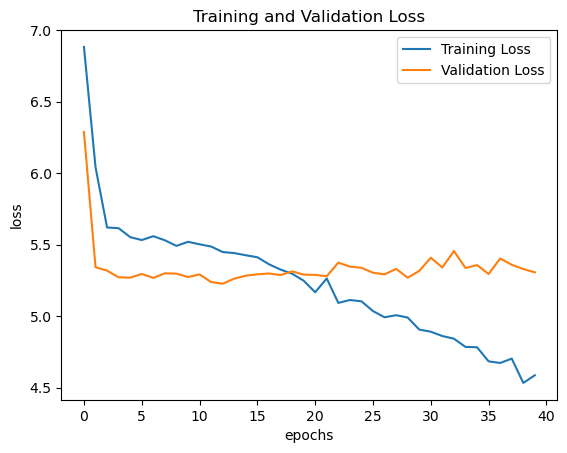

In [163]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

In [164]:
model = torch.load("tut2-model.pth")

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.464 | Test PPL: 236.091 |


In [168]:
def answer_question(
    question,
    model,
    question_vocab,
    answer_vocab,
    sos_token,
    eos_token,
    device,
    max_output_length=100,
):
    model.eval()
    with torch.no_grad():
        if isinstance(question, str):
            question_tokens = [token.text for token in en_nlp.tokenizer(question)]
        else:
            question_tokens = [token for token in question]
        question_tokens = [token.lower() for token in question_tokens]
        question_tokens = [sos_token] + question_tokens + [eos_token]
        ids = question_vocab.lookup_indices(question_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = answer_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == answer_vocab[eos_token]:
                break
        answer_tokens = answer_vocab.lookup_tokens(inputs)
    return answer_tokens, question_tokens, attentions[: len(answer_tokens) - 1]


In [169]:
question = test_data[2]["Questions"]
expected_answer = test_data[2]["Answers"]

question, expected_answer

('How can I find a support group?',
 'Support groups are a way for people with a common experience to help each other and learn from each other. There are support groups for people with any experience of mental illness, support groups for people with a specific diagnosis, support groups for family members and friends, and more. \n Support groups are offered by community organizations, mental health service providers, schools, campuses, and support agencies. Here are some general resources to help you find a mental health or substance use related support group in BC: \n Talk to your mental health care provider. They might be able to make recommendations. \n The Mood Disorders Association of BC offers a network of peer support groups around the province for people who experience mental illnesses like mood disorders or post-traumatic stress disorder. They also have groups for family and friends. Groups are drop-in. \n Many Canadian Mental Health Association branches offer support services

In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

answer, _, _ = answer_question(
    question,
    model,
    question_vocab,
    answer_vocab,
    sos_token,
    eos_token,
    device
)

answer

['<sos>',
 'a',
 'mental',
 'health',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'doctor',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'doctor',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'doctor',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'doctor',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'doctor',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'health',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'health',
 '.',
 '\n ',
 'you',
 'can',
 'be',
 'a',
 'health',
 '.',
 '\n ']

In [172]:
answer, _, _ = answer_question(
    'What is depression?',
    model,
    question_vocab,
    answer_vocab,
    sos_token,
    eos_token,
    device
)

answer

['<sos>',
 'sometimes',
 ',',
 'a',
 'mental',
 'health',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and',
 '<unk>',
 ',',
 'and']

In [173]:
answers = [
    answer_question(
        example['Questions'],
        model,
        question_vocab,
        answer_vocab,
        sos_token,
        eos_token,
        device
    )[0]
    for example in tqdm.tqdm(test_data)
]


100%|██████████| 21/21 [00:01<00:00, 13.17it/s]


In [174]:
import evaluate

bleu = evaluate.load("bleu")

In [175]:
predictions = [" ".join(answer[1:-1]) for answer in answers]

references = [[example["Answers"]] for example in test_data]

In [176]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [177]:
tokenizer_fn = get_tokenizer_fn(en_nlp, True)

In [178]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

The bleu score is very low...

In [179]:
results

{'bleu': 0.0,
 'precisions': [0.17946505608283003,
  0.019386574074074073,
  0.0005822416302765648,
  0.0],
 'brevity_penalty': 0.3035771064145183,
 'length_ratio': 0.4561794804513251,
 'translation_length': 3477,
 'reference_length': 7622}